In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
groups = pd.read_csv('groups.csv', sep=";")
checks = pd.read_csv('checks.csv', sep=";")
active = pd.read_csv('active_studs.csv', sep=";")

# Конверсия активных пользователей в покупку

Тестируем новую механику способа оплаты, поэтому для анализа будут нужны только активные во время эксперимента пользователи.

In [4]:
df = pd.merge(active, groups, left_on = "student_id", right_on = "id", how = "left")
df.drop('student_id', axis=1, inplace=True)
df = pd.merge(df, checks, left_on = "id", right_on = "student_id", how = "left")
df.drop('student_id', axis=1, inplace=True)
df["order"] = df.rev.notnull() + 0
df.rev.fillna(0, inplace=True)
df.head()

,id,grp,rev,order
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


Описательная статистика по конверсиям активных пользователей в покупку для групп А и В:

In [48]:
df.groupby('grp')['order'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,0.050715,0.219487,0.0,0.0,0.0,0.0,1.0
B,6803.0,0.046156,0.209838,0.0,0.0,0.0,0.0,1.0


Размеры выборок отличаются, поэтому оценка результатов в целевой группе будет точнее, чем в контрольной. Конверсия активных пользователей в заказ в группе В оказалась немного ниже. Размер выборок позволяет воспользоваться нормальным приближением для вероятности покупки. Так как конверсия в покупку в группе В меньше, чем в группе А, выбираем двухсторонний z-тест с уровнем значимости 0,05.

H0: conversion_rate(A) = conversion_rate(B)

H1: conversion_rate(A) != conversion_rate(B)

Тестируем:

In [7]:
A_results = df[df.grp == 'A']['order']
B_results = df[df.grp == 'B']['order']
n_con = A_results.count()
n_treat = B_results.count()
successes = [A_results.sum(), B_results.sum()]
n_obs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = n_obs)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')

z statistic: 0.76
p-value: 0.445


Делаем вывод, что новая механика не влияет на конверсию в заказы. Рассчитаем доверительные интервалы для конверсий двух групп:

In [8]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs = n_obs, alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.040, 0.062]
ci 95% for treatment group: [0.041, 0.051]


Оценка конверсии в группе В действительно более точная. Доверительный интервал для конверсии в контрольной группе полностью вмещает в себя интервал целевой группы.

# Изменение среднего чека

In [9]:
checks = pd.merge(checks, groups, left_on = "student_id", right_on = "id", how = "left")
checks.drop('id', axis = 1, inplace=True)
checks.head()

,student_id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [10]:
checks.grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

Количество чеков в группе В больше из-за размера группы. Проверим распределения на нормальность:

In [11]:
A_rev = checks[checks.grp == 'A']['rev']
B_rev = checks[checks.grp == 'B']['rev']
stats.normaltest(A_rev), stats.normaltest(B_rev)

(NormaltestResult(statistic=52.21845240353401, pvalue=4.580439316510776e-12),
 NormaltestResult(statistic=33.19587456725772, pvalue=6.18881394639434e-08))

Распределения нормальные, можем воспользоваться t-тестом. Построим графики:

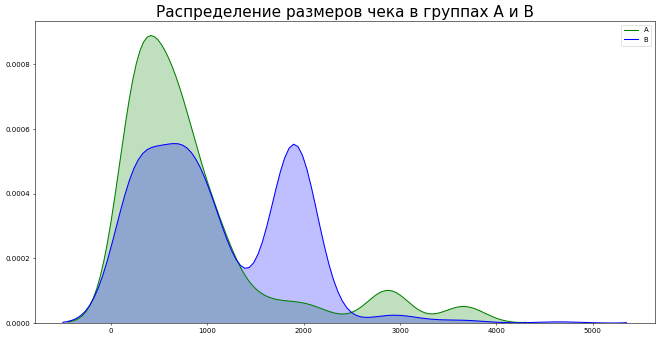

In [12]:
plt.figure(figsize=(16, 8), dpi= 50)
sns.kdeplot(checks[checks.grp == "A"]['rev'], shade = True, color = "g", label = "А")
sns.kdeplot(checks[checks.grp == "B"]['rev'], shade = True, color = "b", label = "В")
plt.title('Распределение размеров чека в группах А и В', fontsize=22)
plt.legend()
plt.show()

Отличия в среднем чеке:

In [46]:
checks.groupby('grp')['rev'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,107.0,860.710280,815.893445,199.0,290.00,690.0,990.0,3660.0
B,434.0,1108.824893,741.834304,199.0,420.75,935.0,1900.0,4650.0


Средний чек группы В больше чека в контрольной группе. Проверим с помощью теста Стьюдента с уровнем значимости 5%, значимы ли отличия:

H0: mean(A_rev) = mean(B_rev)

H1: mean(A_rev) != mean(B_rev)

In [14]:
stats.ttest_ind(A_rev, B_rev).pvalue

0.0025070167572044644

Размер среднего чека значимо вырос с внедрением новой механики оплаты. Проверим также на выборках одного размера:

In [15]:
A_rev1 = checks[checks.grp == 'A']['rev']
B_rev1 = checks[checks.grp == 'B']['rev'].sample(n = 107, random_state = 7)
A_rev1.mean(), B_rev1.mean()

(860.7102803738318, 1109.7383271028039)

In [16]:
stats.ttest_ind(A_rev1, B_rev1).pvalue

0.019166692295283172

Значимость упала, но результаты теста не превышают критического значения. Новая механика оплаты действительно увеличила размер среднего чека.

In [24]:
cm = sms.CompareMeans(sms.DescrStatsW(B_rev), sms.DescrStatsW(A_rev))
cm.tconfint_diff(usevar='unequal')

(77.13670916160842, 419.09251626584296)

Наблюдаем среднее увеличение размера покупки в пределах от 77 до 419 рублей. Построим боксплот для размеров чеков в контрольной и целевой группах:

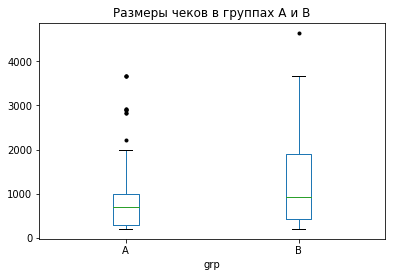

In [49]:
checks.boxplot(column='rev', by='grp', sym='k.') 
plt.title('Размеры чеков в группах А и В', fontsize=12)
plt.suptitle('')
plt.grid(False);
plt.show()

# Выводы

В анализе эффективности новой механики оплаты участвовали данные по активным во время эксперимента пользователям. Новая механика оплаты не влияет на решение о покупке, но значимо увеличивает размер покупки: в среднем, размер покупки увеличился на 77-419 рублей. Результаты теста говорят о том, что механика эффективна и ее стоит запустить для всех пользователей.